In [ ]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import make_column_transformer

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
df = pd.read_excel(url)

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Minute'] = df['InvoiceDate'].dt.minute
df['Invoice_str'] = df['Invoice'].astype(str)
df['CustomerID_str'] = df['Customer ID'].astype(str)
df['StockCode_str'] = df['StockCode'].astype(str)
df.dropna(how= 'any')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,Hour,Minute,Invoice_str,CustomerID_str,StockCode_str
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,85048
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,79323P
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,79323W
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,22041
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,21232


In [ ]:
df['Quarter'] = df['InvoiceDate'].dt.quarter
df['TotalAmount'] = df['Quantity'] * df['Price']

In [ ]:
# Feature Engineering Puchase Variables For Each Unique Customer

MonthlyPurchaseQuantity = df.groupby(['Customer ID', 'Month'])['Quantity'].sum().reset_index()
df = pd.merge(df, MonthlyPurchaseQuantity, on= ['Customer ID', 'Month'], suffixes= ['', '_perMonth'])

MonthlyPurchaseAmount = df.groupby(['Customer ID', 'Month'])['TotalAmount'].sum().reset_index()
df = pd.merge(df, MonthlyPurchaseAmount, on= ['Customer ID', 'Month'], suffixes= ['', '_perMonth'])

YearlyPurchaseQuantity = df.groupby(['Customer ID', 'Year'])['Quantity'].sum().reset_index()
df  = pd.merge(df, YearlyPurchaseQuantity, on= ['Customer ID', 'Year'], suffixes= ['', '_perYear'])

YearlyPurchaseAmount = df.groupby(['Customer ID', 'Year'])['TotalAmount'].sum().reset_index()
df = pd.merge(df, YearlyPurchaseAmount, on= ['Customer ID', 'Year'], suffixes= ['', '_perYear'])

In [ ]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Month', 'Year', 'Day', 'Hour',
       'Minute', 'Invoice_str', 'CustomerID_str', 'StockCode_str', 'Quarter',
       'TotalAmount', 'Quantity_perMonth', 'TotalAmount_perMonth',
       'Quantity_perYear', 'TotalAmount_perYear'],
      dtype='object')

############################################ Clustering Model #################### Can customers be segmented based on purchasing behavior (frequent buyer, seasonal buyer, occasional buyer, etc.) through the use of clustering? This is done through feature engineering the variables purchase quantity per month, purchase amount permonth,purchase amount per year, purchase quantity per year, and using these variables as predictors. Then clusters can be visualized with scatterplots of these variables

In [ ]:
# K - Means Cluster
X_train = df[['Quantity_perMonth', 'TotalAmount_perMonth', 'Quantity_perYear',  'TotalAmount_perYear']]

#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_std = scaler.transform(X_train)

model = KMeans(n_clusters=4) # 4 Clusters were chosen as this seems to provide the most distinct clusters
model.fit(X_train)

purchaseColors = pd.Series(model.labels_).map({
    0: "blue",
    1: "yellow",
    2: "green",
    3: "red"
})

purchaseClusters = model.labels_

df['PurchaseClusters'] = purchaseClusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='Quantity_perMonth', ylabel='TotalAmount_perMonth'>

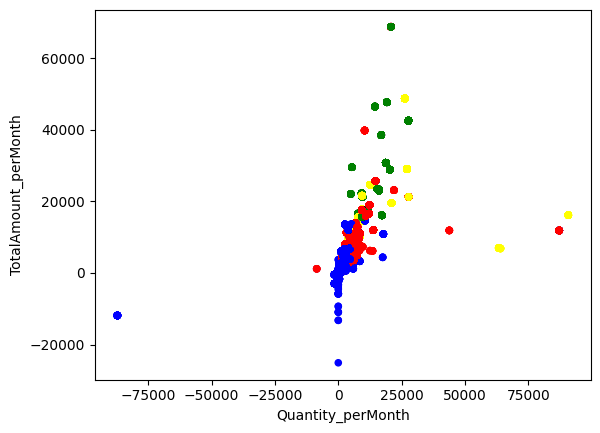

In [ ]:
# Base Clustering Scatter Plot between quantity a customer purchased for a given month and total amount spent for that month
df.plot.scatter(x= 'Quantity_perMonth', y= 'TotalAmount_perMonth', c= purchaseColors)

<Axes: xlabel='Quantity_perMonth', ylabel='TotalAmount_perMonth'>

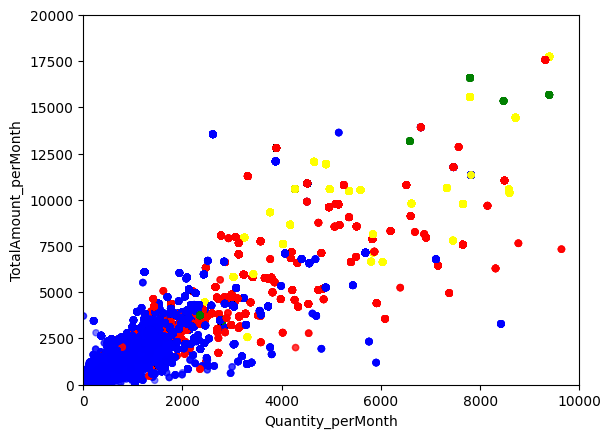

In [ ]:
# Limiting plot size to remove extreme observations and allow for break-down of clusters
df.plot.scatter(x= 'Quantity_perMonth', y= 'TotalAmount_perMonth', c= purchaseColors, xlim= (0,10000), ylim= (0,20000), alpha= 0.5)

<Axes: xlabel='Quantity_perYear', ylabel='TotalAmount_perYear'>

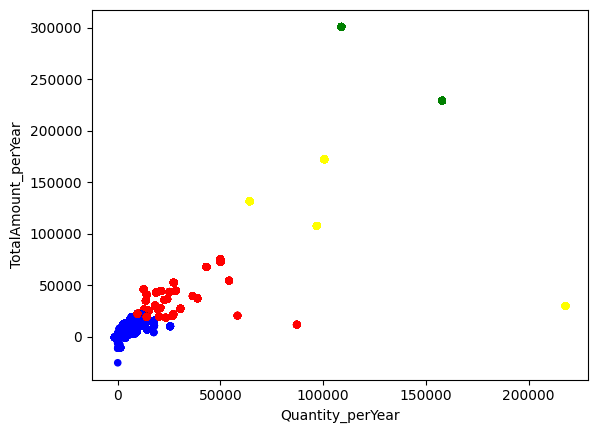

In [ ]:
# Base Clustering Scatter Plot between quantity a customer purchased for a given year and total amount spent for that year
df.plot.scatter(x= 'Quantity_perYear', y= 'TotalAmount_perYear', c= purchaseColors)

<Axes: xlabel='Quantity_perYear', ylabel='TotalAmount_perYear'>

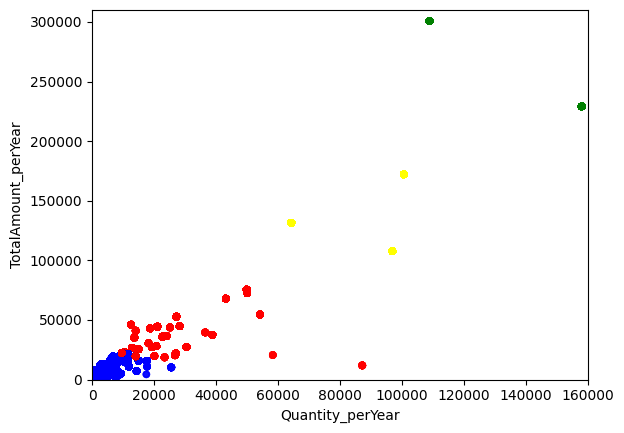

In [ ]:
# Limiting plot size to remove extreme observations and allow for break-down of clusters
df.plot.scatter(x= 'Quantity_perYear', y= 'TotalAmount_perYear', c= purchaseColors, xlim= (0,160000), ylim= (0,310000), alpha= 0.5)

<Axes: xlabel='Quantity_perMonth', ylabel='Quantity_perYear'>

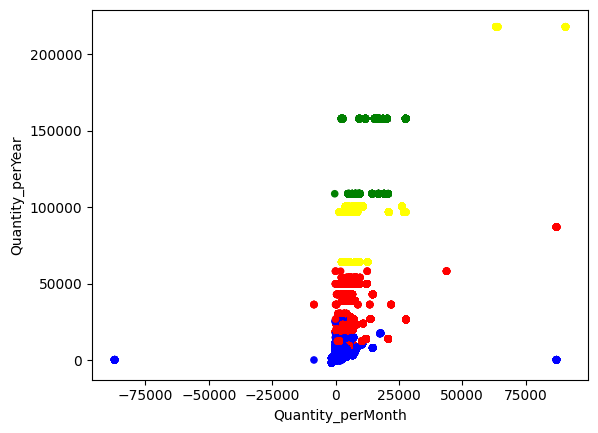

In [ ]:
# Comparing Quantity Per Month to Quantity Per Year
df.plot.scatter(x= 'Quantity_perMonth', y= 'Quantity_perYear', c= purchaseColors)

<Axes: xlabel='Quantity_perMonth', ylabel='Quantity_perYear'>

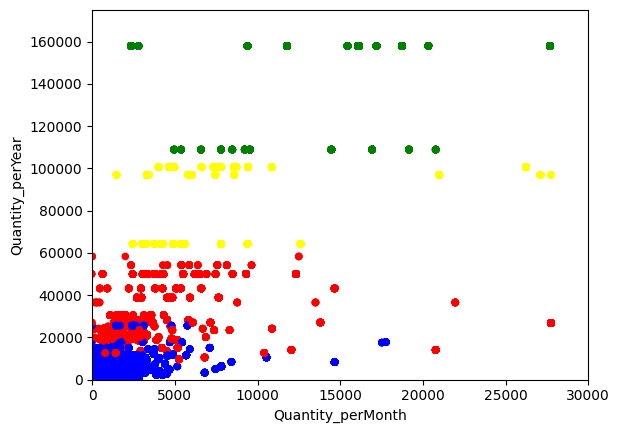

In [ ]:
# Comparing Quantity Per Month to Quantity Per Year excluding unusual observations
df.plot.scatter(x= 'Quantity_perMonth', y= 'Quantity_perYear', c= purchaseColors, xlim= (0, 30000), ylim= (0, 175000))

<Axes: xlabel='TotalAmount_perMonth', ylabel='TotalAmount_perYear'>

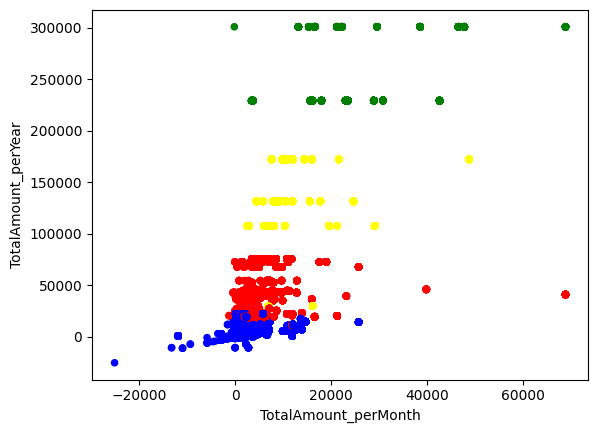

In [ ]:
# Comparing Amount Purchased Per Month to Amount Purchased Per Year
df.plot.scatter(x= 'TotalAmount_perMonth', y= 'TotalAmount_perYear', c= purchaseColors)

<Axes: xlabel='TotalAmount_perMonth', ylabel='TotalAmount_perYear'>

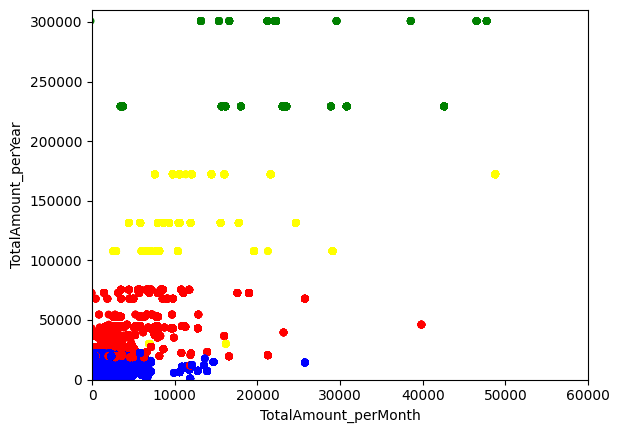

In [ ]:
# Comparing Amount Purchased Per Month to Amount Purchased Per Year excluding unusual observations
df.plot.scatter(x= 'TotalAmount_perMonth', y= 'TotalAmount_perYear', c= purchaseColors, xlim= (0,60000), ylim= (0, 310000))

######################## Clustering Model for item similarities ###########

In [ ]:
df_similar_item = df[['Invoice_str', 'Month', 'Day']]    # [['Invoice_str', 'Price', 'Quantity', 'CustomerID_str', 'Month', 'Day', 'Hour', 'Minute']] - full version

x_train, x_val = train_test_split(df_similar_item, train_size= 0.1) # Using only 10% of data set for training due to limited computation resources and large data set size

df_similar_item = pd.get_dummies(x_train)
df_similar_item.dropna(inplace=True)
df_similar_item.head(2)

scaler = StandardScaler()
scaler.fit(df_similar_item)
std_similar_item = scaler.transform(df_similar_item)

In [ ]:
# K - Means Cluster
X_train = df_similar_item

#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_std = scaler.transform(X_train)

model = KMeans(n_clusters=4) # 4 Clusters were chosen as this seems to provide the most distinct clusters
model.fit(X_train)

purchaseColors = pd.Series(model.labels_).map({
    0: "blue",
    1: "yellow",
    2: "green",
    3: "red"
})

purchaseClusters = model.labels_

df['ItemCategory'] = purchaseClusters